In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 


In [51]:
# import data
housing_data = pd.read_csv("../data/houseprice.csv")
target_var = "SalePrice"

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(housing_data, housing_data[target_var], test_size = 0.1, random_state=0)

In [54]:
X_train.shape, X_test.shape

((1314, 81), (146, 81))

## Missing Values

In [55]:
vars_with_na = [col for col in housing_data.columns if housing_data[col].isnull().sum()>0 and housing_data[col].dtype == 'O']

In [56]:
for var in vars_with_na:
    print(var, housing_data[var].isnull().mean(), " % missing")

Alley 0.9376712328767123  % missing
MasVnrType 0.005479452054794521  % missing
BsmtQual 0.025342465753424658  % missing
BsmtCond 0.025342465753424658  % missing
BsmtExposure 0.026027397260273973  % missing
BsmtFinType1 0.025342465753424658  % missing
BsmtFinType2 0.026027397260273973  % missing
Electrical 0.0006849315068493151  % missing
FireplaceQu 0.4726027397260274  % missing
GarageType 0.05547945205479452  % missing
GarageFinish 0.05547945205479452  % missing
GarageQual 0.05547945205479452  % missing
GarageCond 0.05547945205479452  % missing
PoolQC 0.9952054794520548  % missing
Fence 0.8075342465753425  % missing
MiscFeature 0.963013698630137  % missing


In [57]:
def fill_categorical_na(df, var_list):
    X = df.copy()
    X[var_list] = X[var_list].fillna("missing")
    return X

In [58]:
X_train = fill_categorical_na(X_train, vars_with_na)
X_test = fill_categorical_na(X_test, vars_with_na)

In [59]:
X_train[vars_with_na].isnull().sum()

Alley           0
MasVnrType      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
FireplaceQu     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
PoolQC          0
Fence           0
MiscFeature     0
dtype: int64

In [60]:
vars_with_na = [col for col in housing_data.columns if housing_data[col].dtype != 'O' and housing_data[col].isnull().sum()>0]

In [61]:
for var in vars_with_na:

    mode = X_train[var].mode()[0]
    
    X_train[var+ "_na"] = np.where(X_train[var].isnull(), 1, 0)
    X_train[var].fillna(mode, inplace=True)

    X_test[var + "_na"] = np.where(X_test[var].isnull(), 1, 0)
    X_test[var].fillna(mode, inplace=True)
    

In [62]:
def elapsed_years(df, var):
    df[var] = df['YrSold'] - df[var]
    return df

## Temporal Variables

In [63]:
X_train[vars_with_na].isnull().sum()

LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

In [64]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    elapsed_years(X_train, var)
    elapsed_years(X_test, var)

## Numerical Variables

In [65]:
for var in ['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice']:
    X_train[var] = np.log(X_train[var])
    X_test[var] = np.log(X_test[var])


In [66]:
[vr for vr in ['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice'] if X_train[vr].isnull().sum()>0]

[]

In [67]:
[vr for vr in ['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice'] if X_test[vr].isnull().sum()>0]

[]

## Categorical Variables

In [68]:
cat_vars = [var for var in housing_data.columns if housing_data[var].dtype == 'O']

In [69]:
def find_frequent_labels(df, var, rare_pct):
    df = df.copy()
    tmp = df[var].value_counts(normalize = True)
    return tmp[tmp>rare_pct].index


In [70]:
for var in cat_vars:
    frequent_labels = find_frequent_labels(X_train, var, 0.01)
    X_train[var] = np.where(X_train[var].isin(frequent_labels), X_train[var], "Rare")
    X_test[var] = np.where(X_test[var].isin(frequent_labels), X_test[var], "Rare")

In [71]:
def replace_categories(train , test, var, target):
    ordered_labels = train.groupby(var)[target].mean().sort_values().index
    ordered_label = {k:i for i,k in enumerate(ordered_labels)}
    train[var] = train[var].map(ordered_label)
    test[var] = test[var].map(ordered_label)


In [72]:
for var in cat_vars:
    replace_categories(X_train, X_test, var, 'SalePrice')

In [75]:
def analyse_discrete(df, var):

    df = df.copy()
    df.groupby(var)['SalePrice'].mean().plot(kind='bar')
    plt.xlabel(var)
    plt.ylabel('Sale Price')
    plt.show()

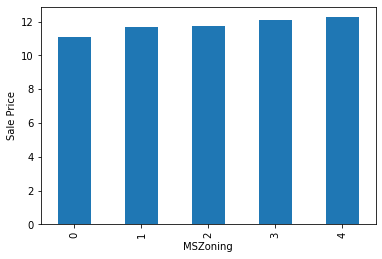

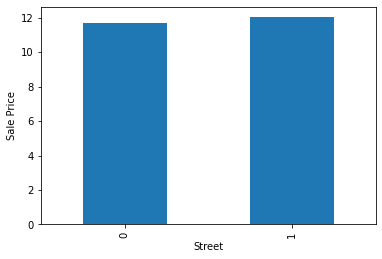

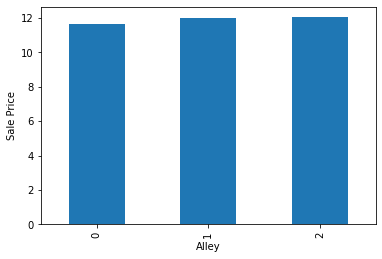

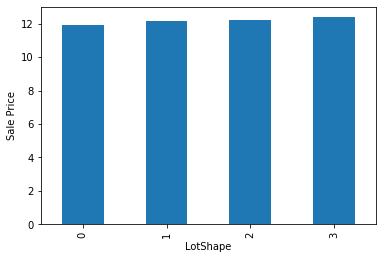

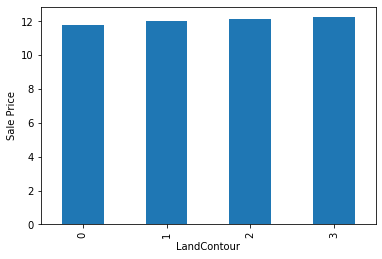

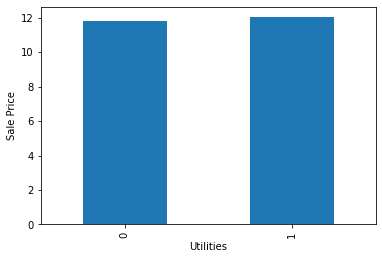

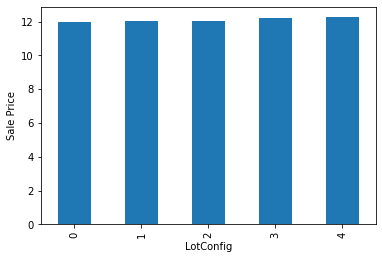

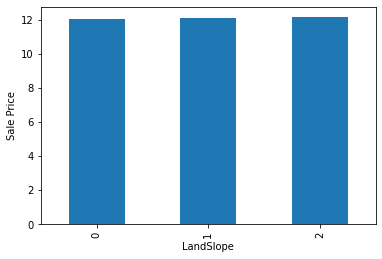

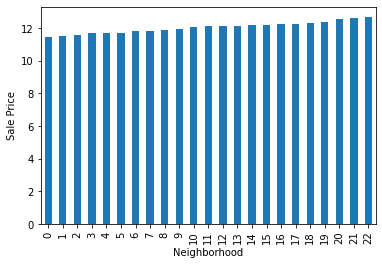

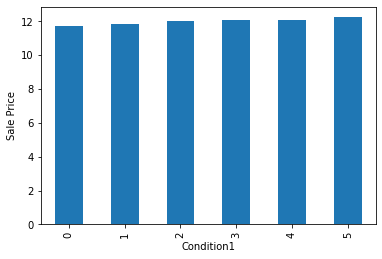

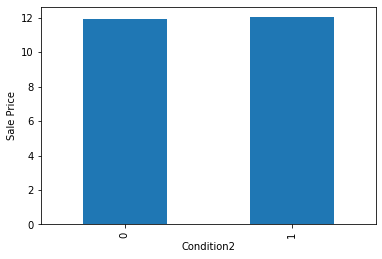

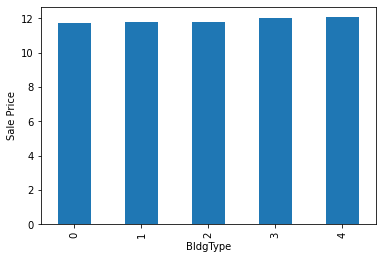

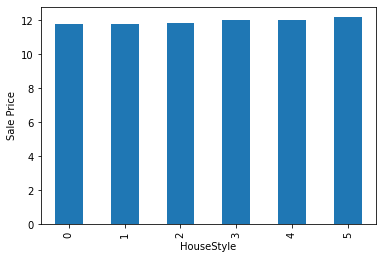

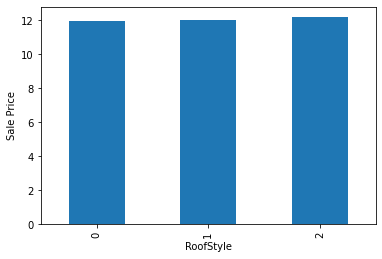

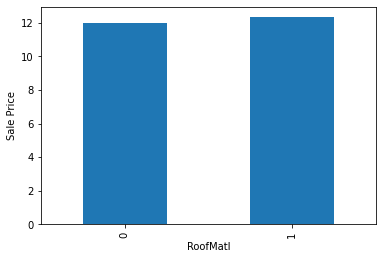

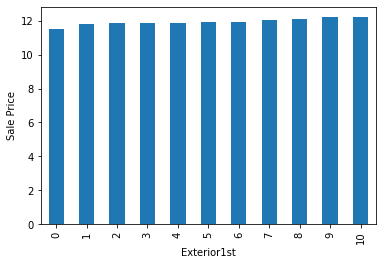

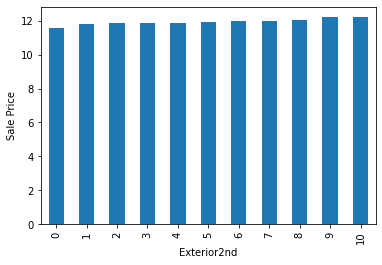

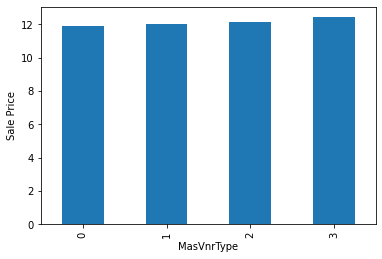

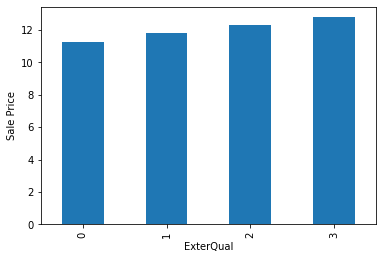

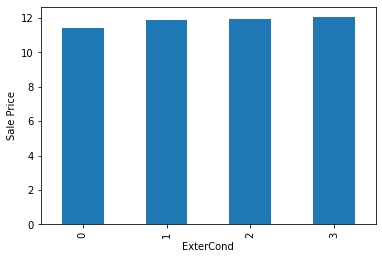

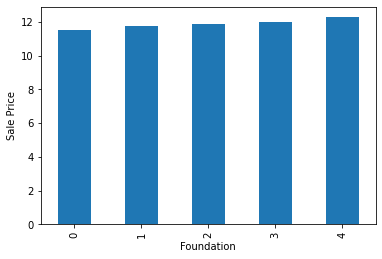

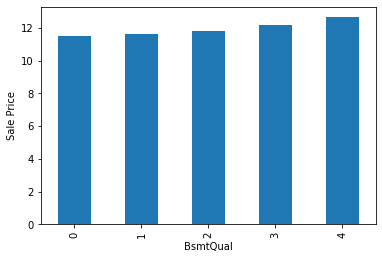

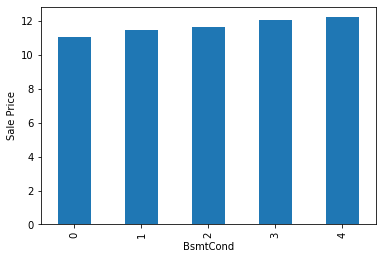

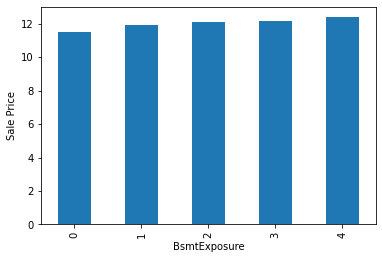

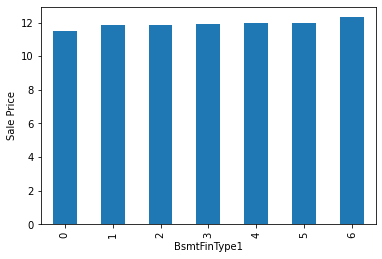

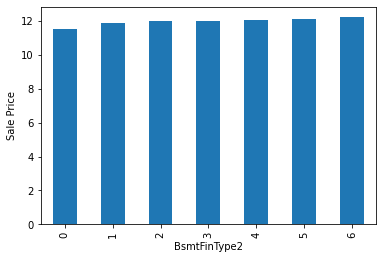

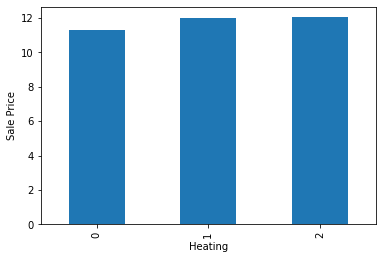

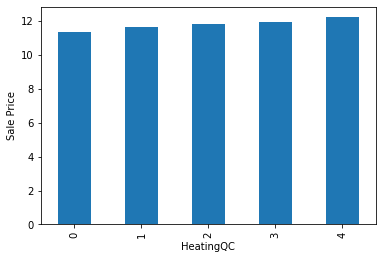

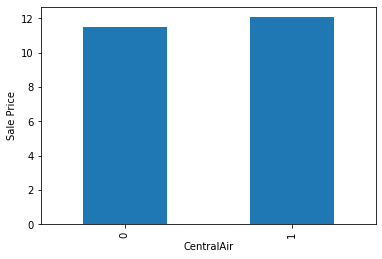

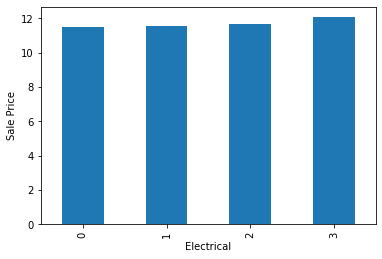

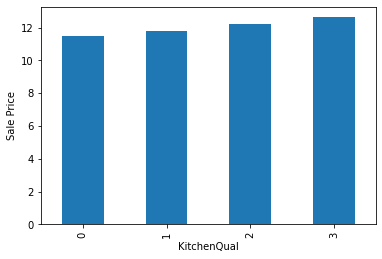

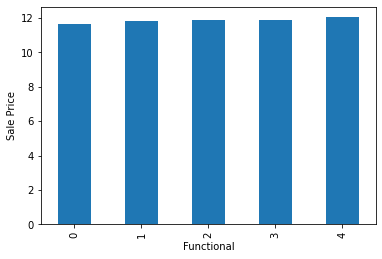

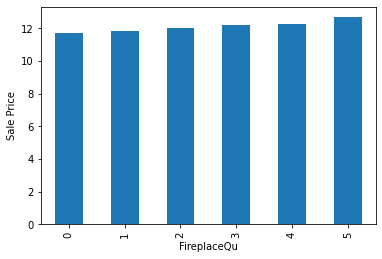

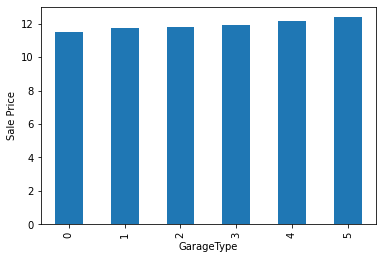

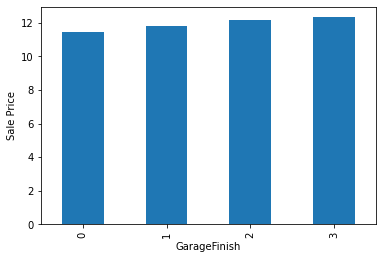

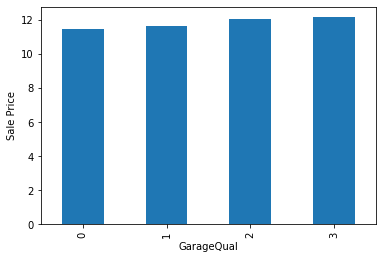

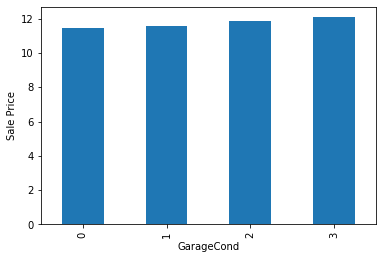

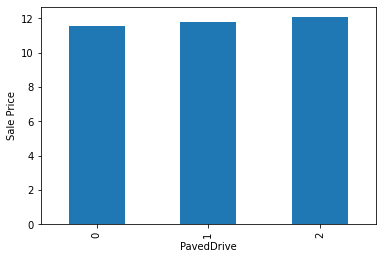

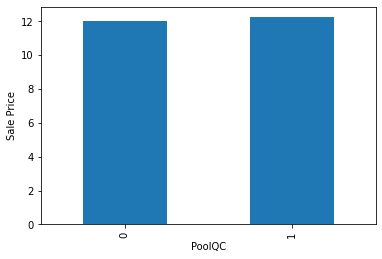

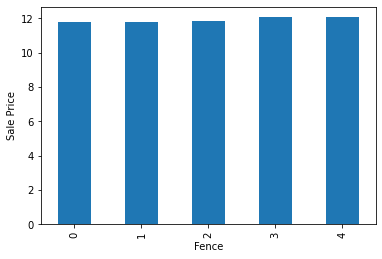

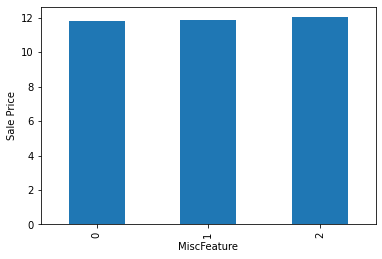

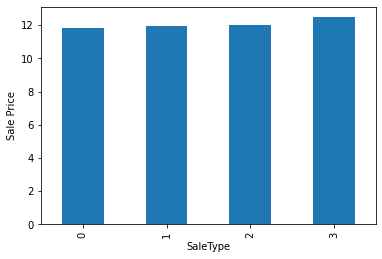

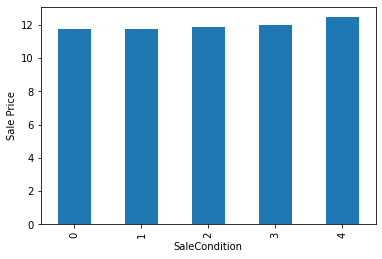

In [76]:
for var in cat_vars:
    analyse_discrete(X_train, var)

In [79]:
train_vars = [col for col in housing_data.columns if col != 'Id' and col != 'SalePrice']


In [81]:
from sklearn.preprocessing import MinMaxScaler

In [82]:
scaler = MinMaxScaler()
scaler.fit(X_train[train_vars])

X_train = pd.concat([X_train[['Id', 'SalePrice']].reset_index(drop=True), 
                    pd.DataFrame(scaler.transform(X_train[train_vars]), columns=train_vars)],
                    axis = 1)
                    
X_test = pd.concat([X_test[['Id', 'SalePrice']].reset_index(drop=True),
                    pd.DataFrame(scaler.transform(X_test[train_vars]), columns=train_vars)],
                    axis = 1)

In [83]:
X_train.head()

,Id,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,931,12.211060,0.000000,0.75,0.461171,0.377048,1.0,1.0,0.333333,1.000000,...,0.0,0.0,0.0,0.75,1.0,0.0,0.545455,0.75,0.666667,0.75
1,657,11.887931,0.000000,0.75,0.456066,0.399443,1.0,1.0,0.333333,0.333333,...,0.0,0.0,0.0,0.50,1.0,0.0,0.636364,0.50,0.666667,0.75
2,46,12.675764,0.588235,0.75,0.394699,0.347082,1.0,1.0,0.000000,0.333333,...,0.0,0.0,0.0,0.75,1.0,0.0,0.090909,1.00,0.666667,0.75
3,1349,12.278393,0.000000,0.75,0.388581,0.493677,1.0,1.0,0.666667,0.666667,...,0.0,0.0,0.0,0.75,1.0,0.0,0.636364,0.25,0.666667,0.75
4,56,12.103486,0.000000,0.75,0.577658,0.402702,1.0,1.0,0.333333,0.333333,...,0.0,0.0,0.0,0.75,1.0,0.0,0.545455,0.50,0.666667,0.75


In [84]:
X_train.to_csv('../data/train.csv')
X_test.to_csv('../data/test.csv')